In [4]:
import os
import pandas as pd
import numpy as np
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [5]:
metadata_path = r'C:\Users\HP\Documents\Mtech\Speech Understanding\UrbanSound8K\UrbanSound8K\metadata\UrbanSound8K.csv'
audio_dir = r'C:\Users\HP\Documents\Mtech\Speech Understanding\UrbanSound8K\UrbanSound8K\audio'  
sample_rate = 22050
duration = 4  
target_samples = sample_rate * duration
n_fft = 512  
hop_length = 256
window_length = n_fft
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
metadata = pd.read_csv(metadata_path)

In [7]:
features_hann, features_hamming, features_rect = [], [], []
labels = []

In [8]:
def load_audio(file_path, target_samples):
    waveform, sr = torchaudio.load(file_path)
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(sr, sample_rate)
        waveform = resampler(waveform)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    if waveform.shape[1] < target_samples:
        pad = target_samples - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, pad))
    else:
        waveform = waveform[:, :target_samples]
    assert waveform.shape[1] == target_samples, \
        f"Bad length: {waveform.shape[1]} vs {target_samples} in {file_path}"
    return waveform.to(device)

In [9]:
def compute_spectrogram(waveform, window):
    stft = torch.stft(
        waveform.squeeze(0), 
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=window_length,
        window=window,
        center=True,
        pad_mode='reflect',
        normalized=False,
        onesided=True,
        return_complex=True
    )
    spectrogram = torch.abs(stft) ** 2
    log_spectrogram = torch.log10(spectrogram + 1e-10)
    
    mean = torch.mean(log_spectrogram)
    std = torch.std(log_spectrogram)
    norm_log_spectrogram = (log_spectrogram - mean) / (std + 1e-9)
    
    expected_time_frames = (target_samples + n_fft - hop_length) // hop_length
    expected_shape = (n_fft//2 + 1, expected_time_frames)
    assert log_spectrogram.shape == expected_shape, \
        f"Bad spectrogram shape: {log_spectrogram.shape} vs {expected_shape}"
    
    return norm_log_spectrogram


In [10]:
features_hann, features_hamming, features_rect = [], [], []
labels = []
failed_files = []


In [11]:
for idx, row in metadata.iterrows():
    file_path = os.path.join(audio_dir, f'fold{row["fold"]}', row['slice_file_name'])
    try:
        waveform = load_audio(file_path, target_samples)
        
        hann_window = torch.hann_window(window_length).to(device)
        hamming_window = torch.hamming_window(window_length).to(device)
        rect_window = torch.ones(window_length).to(device)
        
        spec_hann = compute_spectrogram(waveform, hann_window)
        spec_hamming = compute_spectrogram(waveform, hamming_window)
        spec_rect = compute_spectrogram(waveform, rect_window)
        
        features_hann.append(spec_hann.cpu().numpy())
        features_hamming.append(spec_hamming.cpu().numpy())
        features_rect.append(spec_rect.cpu().numpy())
        labels.append(row['classID'])
        
    except Exception as e:
        failed_files.append(file_path)
        print(f"Skipping {file_path} due to error: {str(e)}")

print(f"\nFailed to process {len(failed_files)} files. Continuing with {len(features_hann)} samples.")


Failed to process 0 files. Continuing with 8732 samples.


In [12]:
try:
    features_hann = torch.tensor(np.array(features_hann), dtype=torch.float32)
    features_hamming = torch.tensor(np.array(features_hamming), dtype=torch.float32)
    features_rect = torch.tensor(np.array(features_rect), dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)
except Exception as e:
    print("\nFinal shape verification failed. Checking individual spectrogram shapes...")
    shapes = [s.shape for s in features_hann]
    unique_shapes = Counter(shapes)
    print(f"Unique spectrogram shapes: {unique_shapes}")
    raise e

In [13]:
features_hann = features_hann.unsqueeze(1)
features_hamming = features_hamming.unsqueeze(1)
features_rect = features_rect.unsqueeze(1)

In [14]:
def plot_spectrograms():
    class_ids = metadata[['classID', 'class']].drop_duplicates().sort_values('classID')
    class_names = class_ids['class'].tolist()

    idx = 0
    fig, axs = plt.subplots(3, 1, figsize=(15, 12), constrained_layout=True)
    cmap = "viridis"
    
    spectrograms = [
        features_hann[idx][0].cpu().numpy(),
        features_hamming[idx][0].cpu().numpy(),
        features_rect[idx][0].cpu().numpy(),
    ]

    img = None
    for ax, feature, title in zip(
        axs, spectrograms, ["Hann Window", "Hamming Window", "Rectangular Window"]
    ):
        feature = feature[:, np.any(feature > 1e-3, axis=0)]  
        img = ax.imshow(feature, aspect='auto', origin='lower', cmap=cmap, interpolation='nearest')
        ax.set_title(f'{title} ({class_names[labels[idx].item()]})')
        ax.set_ylabel('Frequency Bin')

    axs[-1].set_xlabel('Time Frame')

    cbar = fig.colorbar(img, ax=axs, location='right', shrink=0.85)
    cbar.set_label('Amplitude (Spectrogram Intensity)', rotation=270, labelpad=20)

    plt.show()

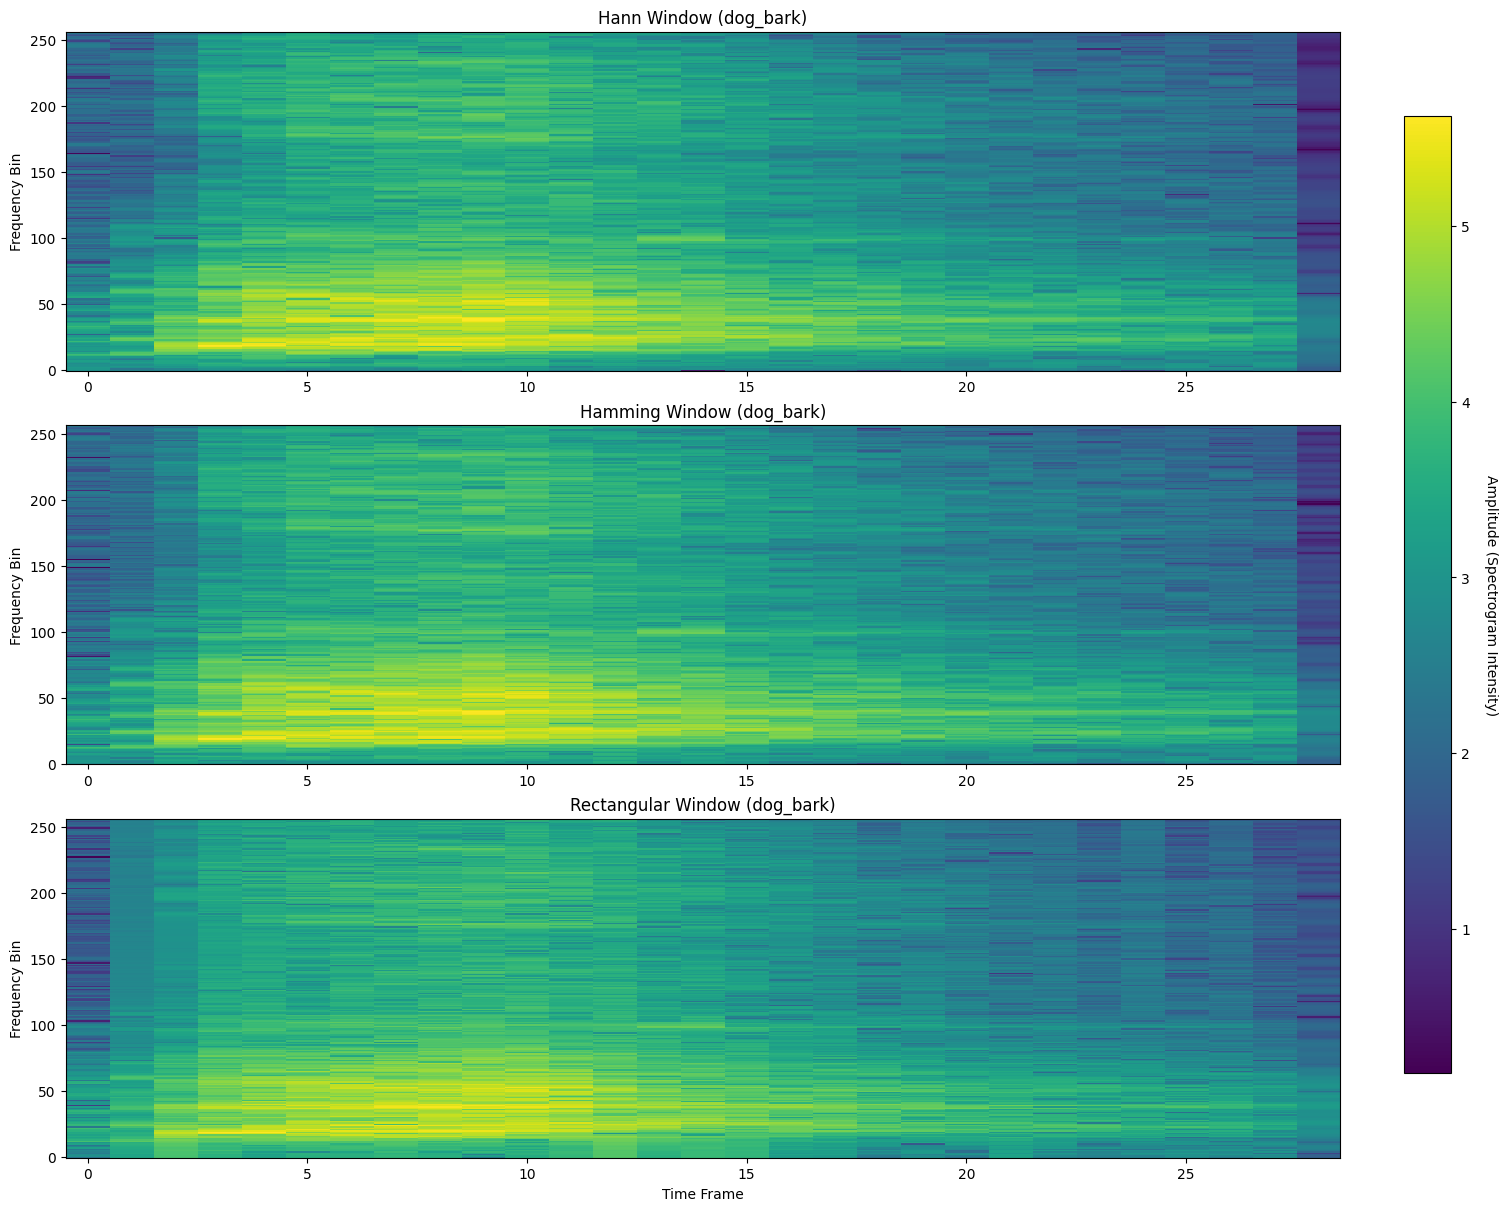

In [15]:
plot_spectrograms()

In [16]:
class AudioClassifier(nn.Module):
    def __init__(self):
        super(AudioClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = None
        self.fc2 = nn.Linear(128, 10) 

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        
        if self.fc1 is None:
            fc1_input_dim = x.size(1)
            self.fc1 = nn.Linear(fc1_input_dim, 128).to(x.device)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


def train_model(features, labels, window_name, num_epochs=20):  
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    model = AudioClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

    best_val_acc = 0
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, batch_labels in train_loader:
            inputs, batch_labels = inputs.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_labels.size(0)
            correct_train += (predicted == batch_labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_acc_history.append(train_acc)

        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0

        with torch.no_grad():
            for inputs, batch_labels in test_loader:
                inputs, batch_labels = inputs.to(device), batch_labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += batch_labels.size(0)
                correct_val += (predicted == batch_labels).sum().item()

        val_loss /= len(test_loader)
        val_acc = 100 * correct_val / total_val
        val_acc_history.append(val_acc)
        best_val_acc = max(best_val_acc, val_acc)
        
        scheduler.step(val_acc)

        print(f"\n{window_name} Window - Epoch {epoch + 1}/{num_epochs}")
        print(f"  Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.2f}%")
        print(f"  Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

    print(f"\n{window_name} Window - Final Performance")
    print(f"  Best Training Accuracy: {max(train_acc_history):.2f}%")
    print(f"  Best Validation Accuracy: {max(val_acc_history):.2f}%")

    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, batch_labels in test_loader:
            inputs, batch_labels = inputs.to(device), batch_labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(batch_labels.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nFinal {window_name} Window Model Accuracy: {acc:.2f}")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {window_name} Window Model')
    plt.show()

    return model



Training with Hann Window:



Hann Window - Epoch 1/20
  Training Loss: 2.0693 | Training Accuracy: 21.99%
  Validation Loss: 1.8964 | Validation Accuracy: 33.20%

Hann Window - Epoch 2/20
  Training Loss: 1.8684 | Training Accuracy: 30.91%
  Validation Loss: 1.7413 | Validation Accuracy: 35.55%

Hann Window - Epoch 3/20
  Training Loss: 1.7591 | Training Accuracy: 35.42%
  Validation Loss: 1.6396 | Validation Accuracy: 40.24%

Hann Window - Epoch 4/20
  Training Loss: 1.6949 | Training Accuracy: 38.28%
  Validation Loss: 1.5808 | Validation Accuracy: 41.50%

Hann Window - Epoch 5/20
  Training Loss: 1.6415 | Training Accuracy: 39.73%
  Validation Loss: 1.4968 | Validation Accuracy: 44.88%

Hann Window - Epoch 6/20
  Training Loss: 1.5896 | Training Accuracy: 42.28%
  Validation Loss: 1.4692 | Validation Accuracy: 44.93%

Hann Window - Epoch 7/20
  Training Loss: 1.5555 | Training Accuracy: 43.52%
  Validation Loss: 1.4245 | Validation Accuracy: 45.74%

Hann Window - Epoch 8/20
  Training Loss: 1.5212 | Training A

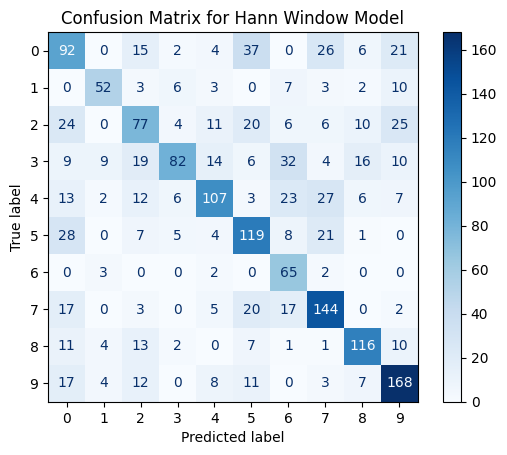

In [45]:
print("\nTraining with Hann Window:")
hann_model = train_model(features_hann, labels, "Hann")


Training with Hamming Window:


c:\Users\HP\Documents\Mtech\Speech Understanding\Assignment\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Hamming Window - Epoch 1/20
  Training Loss: 2.0688 | Training Accuracy: 22.16%
  Validation Loss: 1.8686 | Validation Accuracy: 31.48%

Hamming Window - Epoch 2/20
  Training Loss: 1.8348 | Training Accuracy: 31.67%
  Validation Loss: 1.6902 | Validation Accuracy: 39.32%

Hamming Window - Epoch 3/20
  Training Loss: 1.7193 | Training Accuracy: 36.72%
  Validation Loss: 1.6069 | Validation Accuracy: 42.30%

Hamming Window - Epoch 4/20
  Training Loss: 1.6455 | Training Accuracy: 40.17%
  Validation Loss: 1.5199 | Validation Accuracy: 43.45%

Hamming Window - Epoch 5/20
  Training Loss: 1.5963 | Training Accuracy: 41.62%
  Validation Loss: 1.4554 | Validation Accuracy: 47.34%

Hamming Window - Epoch 6/20
  Training Loss: 1.5495 | Training Accuracy: 43.39%
  Validation Loss: 1.4211 | Validation Accuracy: 47.28%

Hamming Window - Epoch 7/20
  Training Loss: 1.5262 | Training Accuracy: 44.34%
  Validation Loss: 1.4218 | Validation Accuracy: 47.28%

Hamming Window - Epoch 8/20
  Training L

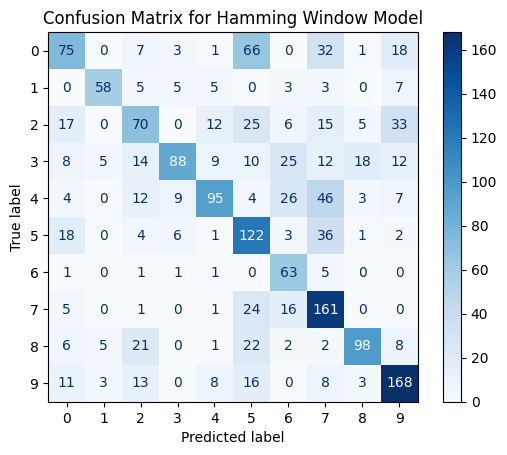

In [ ]:
\
print("\nTraining with Hamming Window:")
hamming_model = train_model(features_hamming, labels, "Hamming")


Training with Rectangular Window:


c:\Users\HP\Documents\Mtech\Speech Understanding\Assignment\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Rectangular Window - Epoch 1/20
  Training Loss: 2.0618 | Training Accuracy: 21.99%
  Validation Loss: 1.8965 | Validation Accuracy: 29.99%

Rectangular Window - Epoch 2/20
  Training Loss: 1.8455 | Training Accuracy: 31.75%
  Validation Loss: 1.7687 | Validation Accuracy: 36.92%

Rectangular Window - Epoch 3/20
  Training Loss: 1.7482 | Training Accuracy: 36.41%
  Validation Loss: 1.6920 | Validation Accuracy: 38.81%

Rectangular Window - Epoch 4/20
  Training Loss: 1.6861 | Training Accuracy: 38.43%
  Validation Loss: 1.6578 | Validation Accuracy: 38.87%

Rectangular Window - Epoch 5/20
  Training Loss: 1.6345 | Training Accuracy: 40.89%
  Validation Loss: 1.5857 | Validation Accuracy: 42.53%

Rectangular Window - Epoch 6/20
  Training Loss: 1.5932 | Training Accuracy: 42.32%
  Validation Loss: 1.5259 | Validation Accuracy: 44.65%

Rectangular Window - Epoch 7/20
  Training Loss: 1.5636 | Training Accuracy: 43.71%
  Validation Loss: 1.5256 | Validation Accuracy: 42.87%

Rectangular 

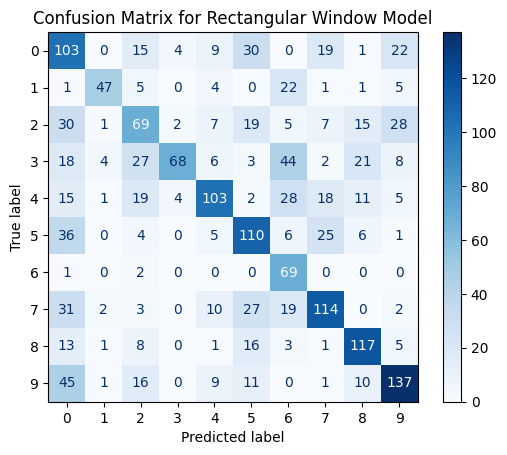

In [18]:
print("\nTraining with Rectangular Window:")
rect_model = train_model(features_rect, labels, "Rectangular")